# Extraction, visualisation and manipulation of spectral data from the RESOURCECODE Hindcast database

The notebook presents some of the functionalities offered by the toolbox. For more details, please refer to the documentation.

In [1]:
import resourcecode
import resourcecode.spectrum

import matplotlib.pyplot as plot

### Find the point location

The function below allows to retreive the location where the spectral dtaa is available. It corresponds to the `orange` dots of the web portal.

In [2]:
resourcecode.get_grid_spec()

longitude  latitude            name      depth       d50
0         1.5000   52.0000   E001500N52000  15.413269  0.737000
1        -5.5000   52.0000   W005500N52000  89.648946 -0.826506
2        -6.0000   52.0000   W006000N52000  95.836144 -1.585000
3        -6.5000   52.0000   W006500N52000  52.674089  0.737000
4        -7.0000   52.0000   W007000N52000  54.674644  0.034650
...          ...       ...             ...        ...       ...
24271     2.4392   51.3894      WESTHINDER  23.067135  0.364202
24272     3.4155   51.4334  WIELINGENNOORD   8.367460  0.734515
24273     6.0640   53.4100    WIERUMERWAD2   3.000000  1.322000
24274     6.0638   53.4090    WIERUMERWAD3   3.000000  1.322000
24275     4.0084   51.9922    ZDV8-2D-MMND  12.754536  1.099299

[24276 rows x 5 columns]

For the demo, we choose a location next to the coast of Britanny where we want to extract the data. We can use the function `get_closest_station` with the coordinates if we do not know the name of the node. It returns the closest point to the provided coordinates, along with the distance (in meters).

In [3]:
selected_loc = resourcecode.data.get_closest_station(
    latitude= 48.2, longitude=-4.8
)
selected_loc

('W004800N48197', 332.21)

In the next block, we propose to plot the area around the selected location.

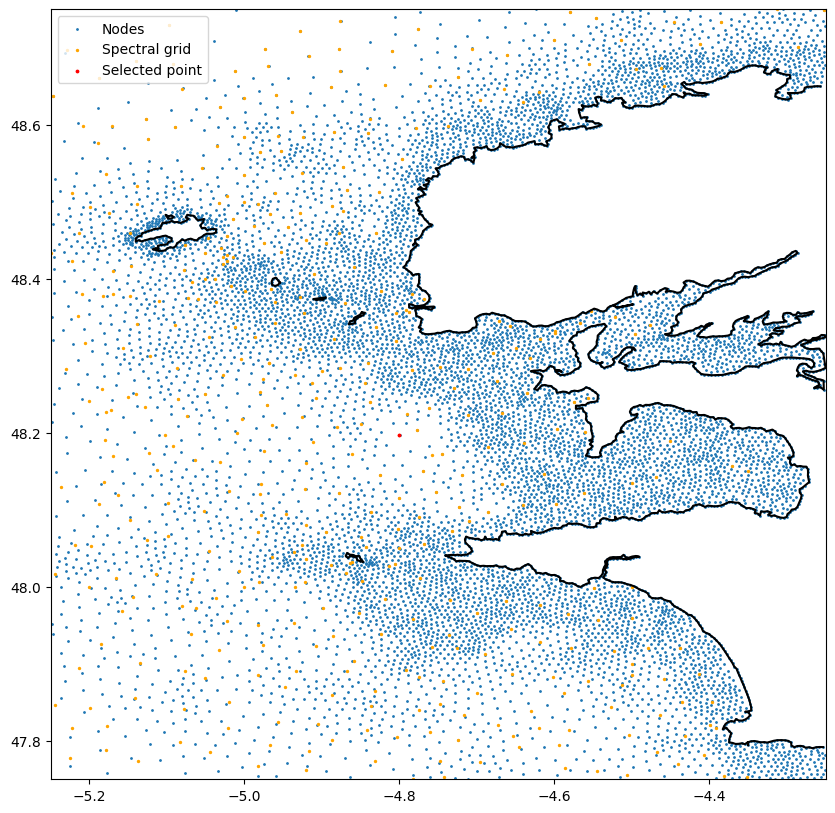

In [4]:
lat_min, lat_max = 47.75, 48.75
lon_min, lon_max = -5.25, -4.25

nodes = resourcecode.data.get_grid_field().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
spec = resourcecode.get_grid_spec().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
coast = resourcecode.data.get_coastline().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
islands = resourcecode.data.get_islands().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
plot.figure(figsize=(10, 10))
plot.scatter(nodes.longitude, nodes.latitude, s=1, label="Nodes")
plot.scatter(spec.longitude, spec.latitude, s=2, color="orange", label="Spectral grid")
plot.ylim(lat_min, lat_max)
plot.xlim(lon_min, lon_max)
plot.plot(coast.longitude, coast.latitude, color="black")
classes = list(islands.ID.unique())
for c in classes:
    df2 = islands.loc[islands['ID'] == c]
    plot.plot(df2.longitude, df2.latitude, color="black")
plot.scatter(
    spec[spec.name == selected_loc[0]].longitude,
    spec[spec.name == selected_loc[0]].latitude,
    s=3,
    color="red",
    label="Selected point",
)
plot.legend()
plot.show()

### Extract data using the toolobox

#### 2D spectrum

The function `get_2D_spectrum` gets the data from IFREMER ftp. The data is stored in separated netCDF files which are processed by this function directly. This function returns an *xarray.Dataset*, where the corresponding scale factors, offstets and transformations are automatically applied to get directly the 2D spectral data. 
This function takes several arguments:

- `names`: the *name* of the node;
- `years`: a **list** of *strings* with the years to extract;
- `months`: a **list** of *strings* with the months to extract for each year, starting with a '0'.

The amount of data downloaded can become quickly large (each month represents about 5Mb) so be patient if you retreive the whole time series, depending on you connection.

We show an example here, with the data from **01/01/2019** to **31/06/2017**.

In [5]:
spec_2D = resourcecode.spectrum.get_2D_spectrum(selected_loc[0],["2019"],[(str(i).zfill(2)) for i in range(1,7)])

In [6]:
spec_2D

<xarray.Dataset>
Dimensions:     (time: 4344, frequency: 36, direction: 36)
Coordinates:
  * time        (time) datetime64[ns] 2019-01-01 ... 2019-06-30T23:00:00
  * frequency   (frequency) float32 0.0339 0.03729 0.04102 ... 0.8661 0.9527
  * direction   (direction) float32 0.0 10.0 20.0 30.0 ... 330.0 340.0 350.0
Data variables:
    longitude   (time) float32 -4.8 -4.8 -4.8 -4.8 -4.8 ... -4.8 -4.8 -4.8 -4.8
    latitude    (time) float32 48.2 48.2 48.2 48.2 48.2 ... 48.2 48.2 48.2 48.2
    frequency1  (frequency) float32 0.0339 0.03559 0.03915 ... 0.8267 0.9094
    frequency2  (frequency) float32 0.03559 0.03915 0.04307 ... 0.9094 0.9527
    dpt         (time) float32 52.5 52.0 51.5 51.0 50.0 ... 49.0 49.0 49.5 50.5
    wnd         (time) float32 2.6 2.8 3.1 2.9 2.6 2.2 ... 4.9 4.8 5.6 5.5 5.1
    wnddir      (time) float32 67.7 67.6 68.6 71.6 ... 316.5 323.0 321.6 318.1
    cur         (time) float32 0.1 0.2 0.2 0.2 0.2 0.1 ... 0.2 0.1 0.1 0.2 0.3
    curdir      (time) float32 328.9 0.0 11.9 20.5 ... 78.8 168.4 190.6 199.7
    Ef          (time, direction, frequency) float32 6.661e-09 ... 1.471e-12
Attributes: (12/98)
    title:                   WAVEWATCH-III HINDCAST
    netcdf_version:          4.5.2
    product_name:            RSCD_WW3-RSCD-UG-W004800N48197_201901_spec.nc
    software_version:        v7.08_e756361_sf/exe_datarmor_intel_Ifremer2
    references:              https://github.com/umr-lops/WW3
    source:                  WAVEWATCH III (R)
    ...                      ...
    EXPFSN:                  T/
    SEDMAPD50:               T
    BOTROUGHMIN:             0.0400
    BOTROUGHFAC:             1.0
    data_type:               OCO spectra 2D
    format_version:          1.1

We propose in this toolbox a plotting function to represent the spectral data at a given time step. We can also remove the informations about the sea-state by specifying `sea_state=False`.

<Figure size 640x480 with 0 Axes>

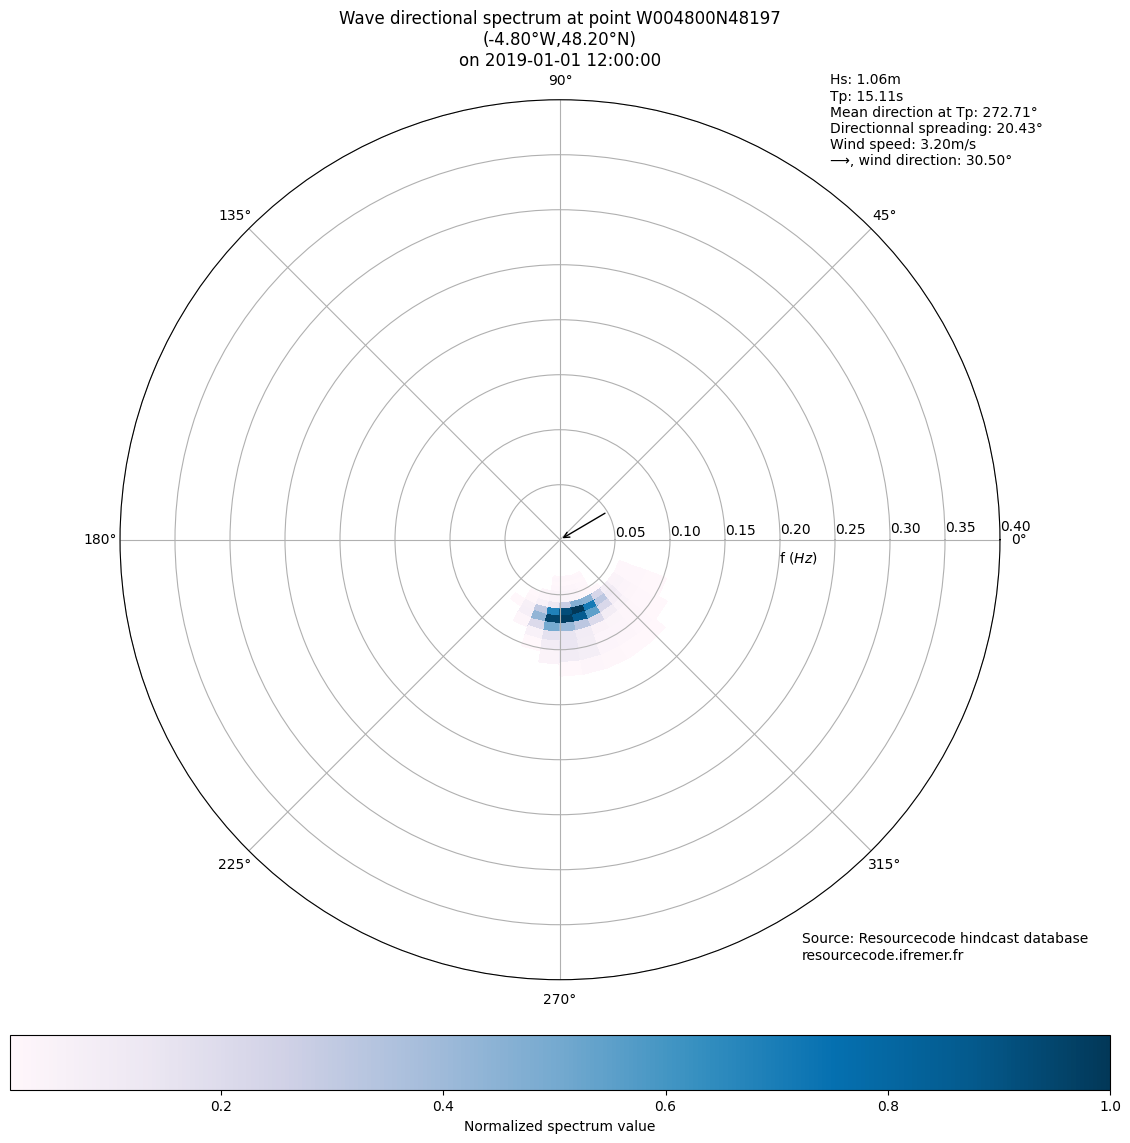

In [7]:
resourcecode.spectrum.plot_2D_spectrum(spec_2D,time=12);

#### 1D spectral data

There are two maner to obtain the 1D spectrm. The first one is to retreive the data from IFREMER **FTP** using the `get_1D_spectrum` function from the toolbox. It will download and process the netCDF files, along with the parameters available in these files, as detailed in the [user manual](https://archimer.ifremer.fr/doc/00751/86306/).

The other option is to compute the 1D spectrum from the 2D, using the `convert_spectrum_2Dto1D` function., as shown below. This times, the sea-state parameters are not computed.

In [8]:
spec_1D_FTP = resourcecode.spectrum.get_1D_spectrum(selected_loc[0],["2019"],[(str(i).zfill(2)) for i in range(1,7)])
spec_1D = resourcecode.spectrum.convert_spectrum_2Dto1D(spec_2D)

In [9]:
spec_1D

<xarray.Dataset>
Dimensions:     (time: 4344, frequency: 36)
Coordinates:
  * time        (time) datetime64[ns] 2019-01-01 ... 2019-06-30T23:00:00
  * frequency   (frequency) float32 0.0339 0.03729 0.04102 ... 0.8661 0.9527
Data variables:
    longitude   (time) float32 -4.8 -4.8 -4.8 -4.8 -4.8 ... -4.8 -4.8 -4.8 -4.8
    latitude    (time) float32 48.2 48.2 48.2 48.2 48.2 ... 48.2 48.2 48.2 48.2
    frequency1  (frequency) float32 0.0339 0.03559 0.03915 ... 0.8267 0.9094
    frequency2  (frequency) float32 0.03559 0.03915 0.04307 ... 0.9094 0.9527
    dpt         (time) float32 52.5 52.0 51.5 51.0 50.0 ... 49.0 49.0 49.5 50.5
    wnd         (time) float32 2.6 2.8 3.1 2.9 2.6 2.2 ... 4.9 4.8 5.6 5.5 5.1
    wnddir      (time) float32 67.7 67.6 68.6 71.6 ... 316.5 323.0 321.6 318.1
    cur         (time) float32 0.1 0.2 0.2 0.2 0.2 0.1 ... 0.2 0.1 0.1 0.2 0.3
    curdir      (time) float32 328.9 0.0 11.9 20.5 ... 78.8 168.4 190.6 199.7
    ef          (time, frequency) float32 9.389e-08 2.838e-06 ... 0.0009619
Attributes: (12/98)
    title:                   WAVEWATCH-III HINDCAST
    netcdf_version:          4.5.2
    product_name:            RSCD_WW3-RSCD-UG-W004800N48197_201901_spec.nc
    software_version:        v7.08_e756361_sf/exe_datarmor_intel_Ifremer2
    references:              https://github.com/umr-lops/WW3
    source:                  WAVEWATCH III (R)
    ...                      ...
    EXPFSN:                  T/
    SEDMAPD50:               T
    BOTROUGHMIN:             0.0400
    BOTROUGHFAC:             1.0
    data_type:               OCO spectra 2D
    format_version:          1.1

We propose in this toolbox a plotting function to represent the spectral data at a given time step. We can also remove the informations about the sea-state by specifying `sea_state=False`.

<Figure size 640x480 with 0 Axes>

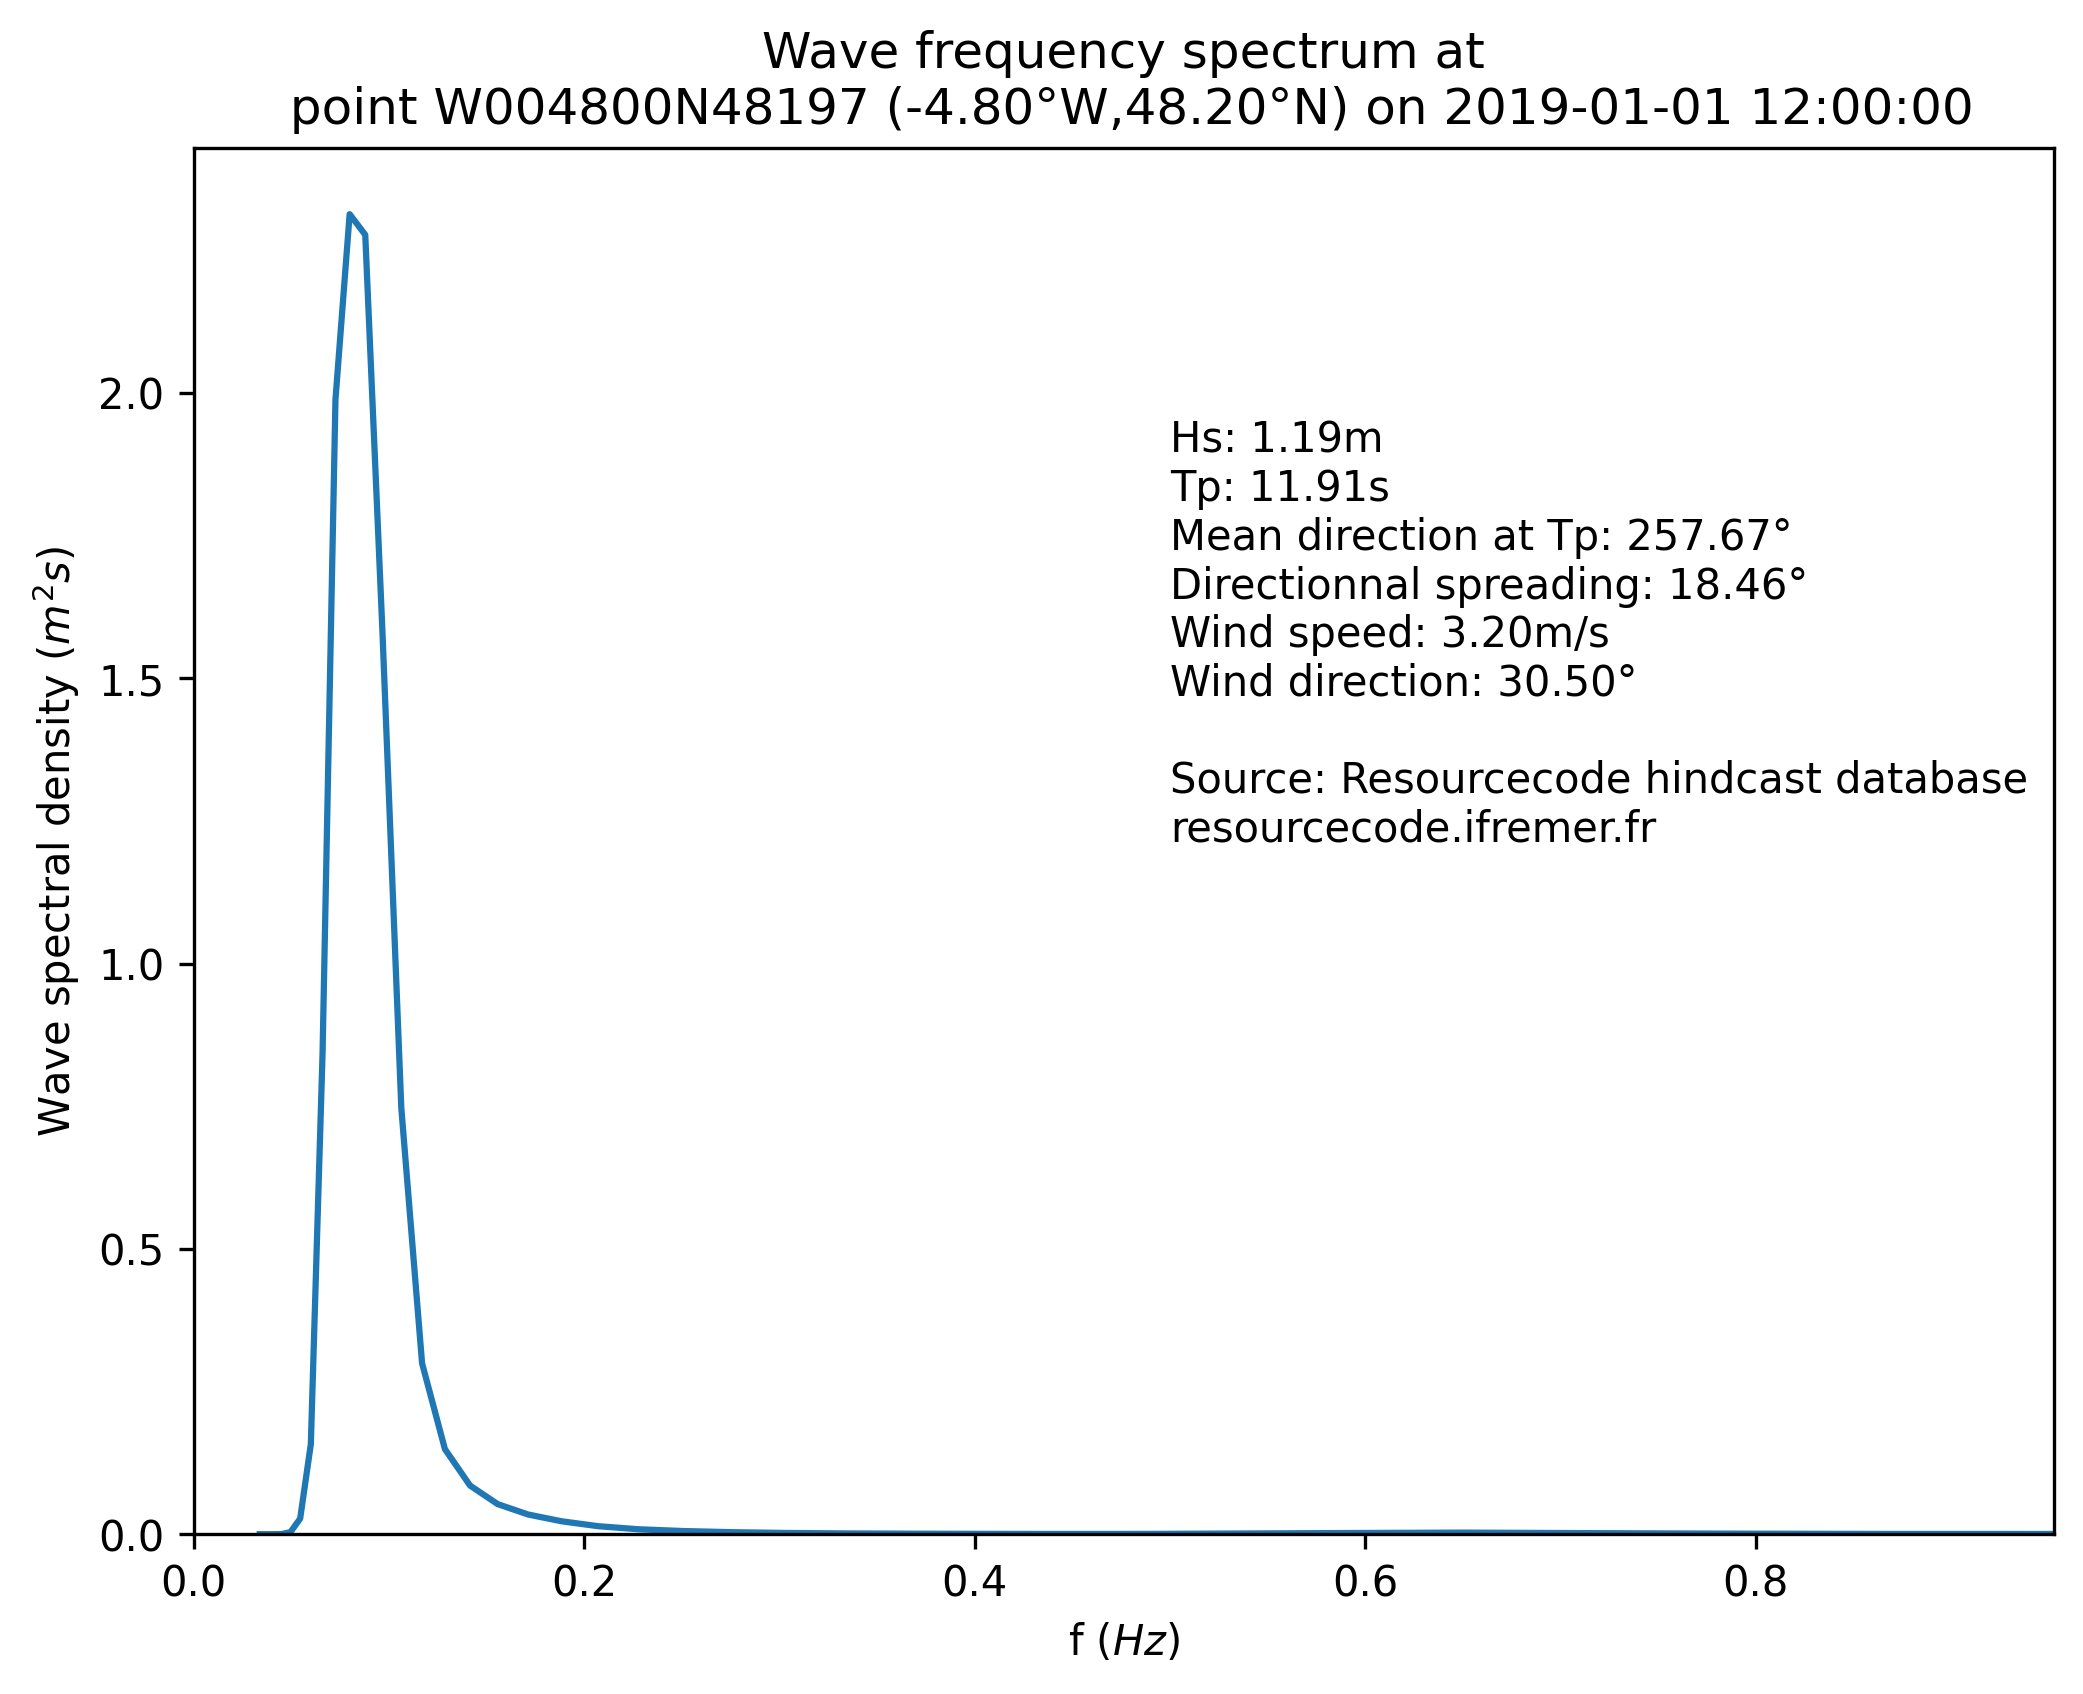

In [10]:
resourcecode.spectrum.plot_1D_spectrum(spec_1D_FTP,time=12);

<Figure size 640x480 with 0 Axes>

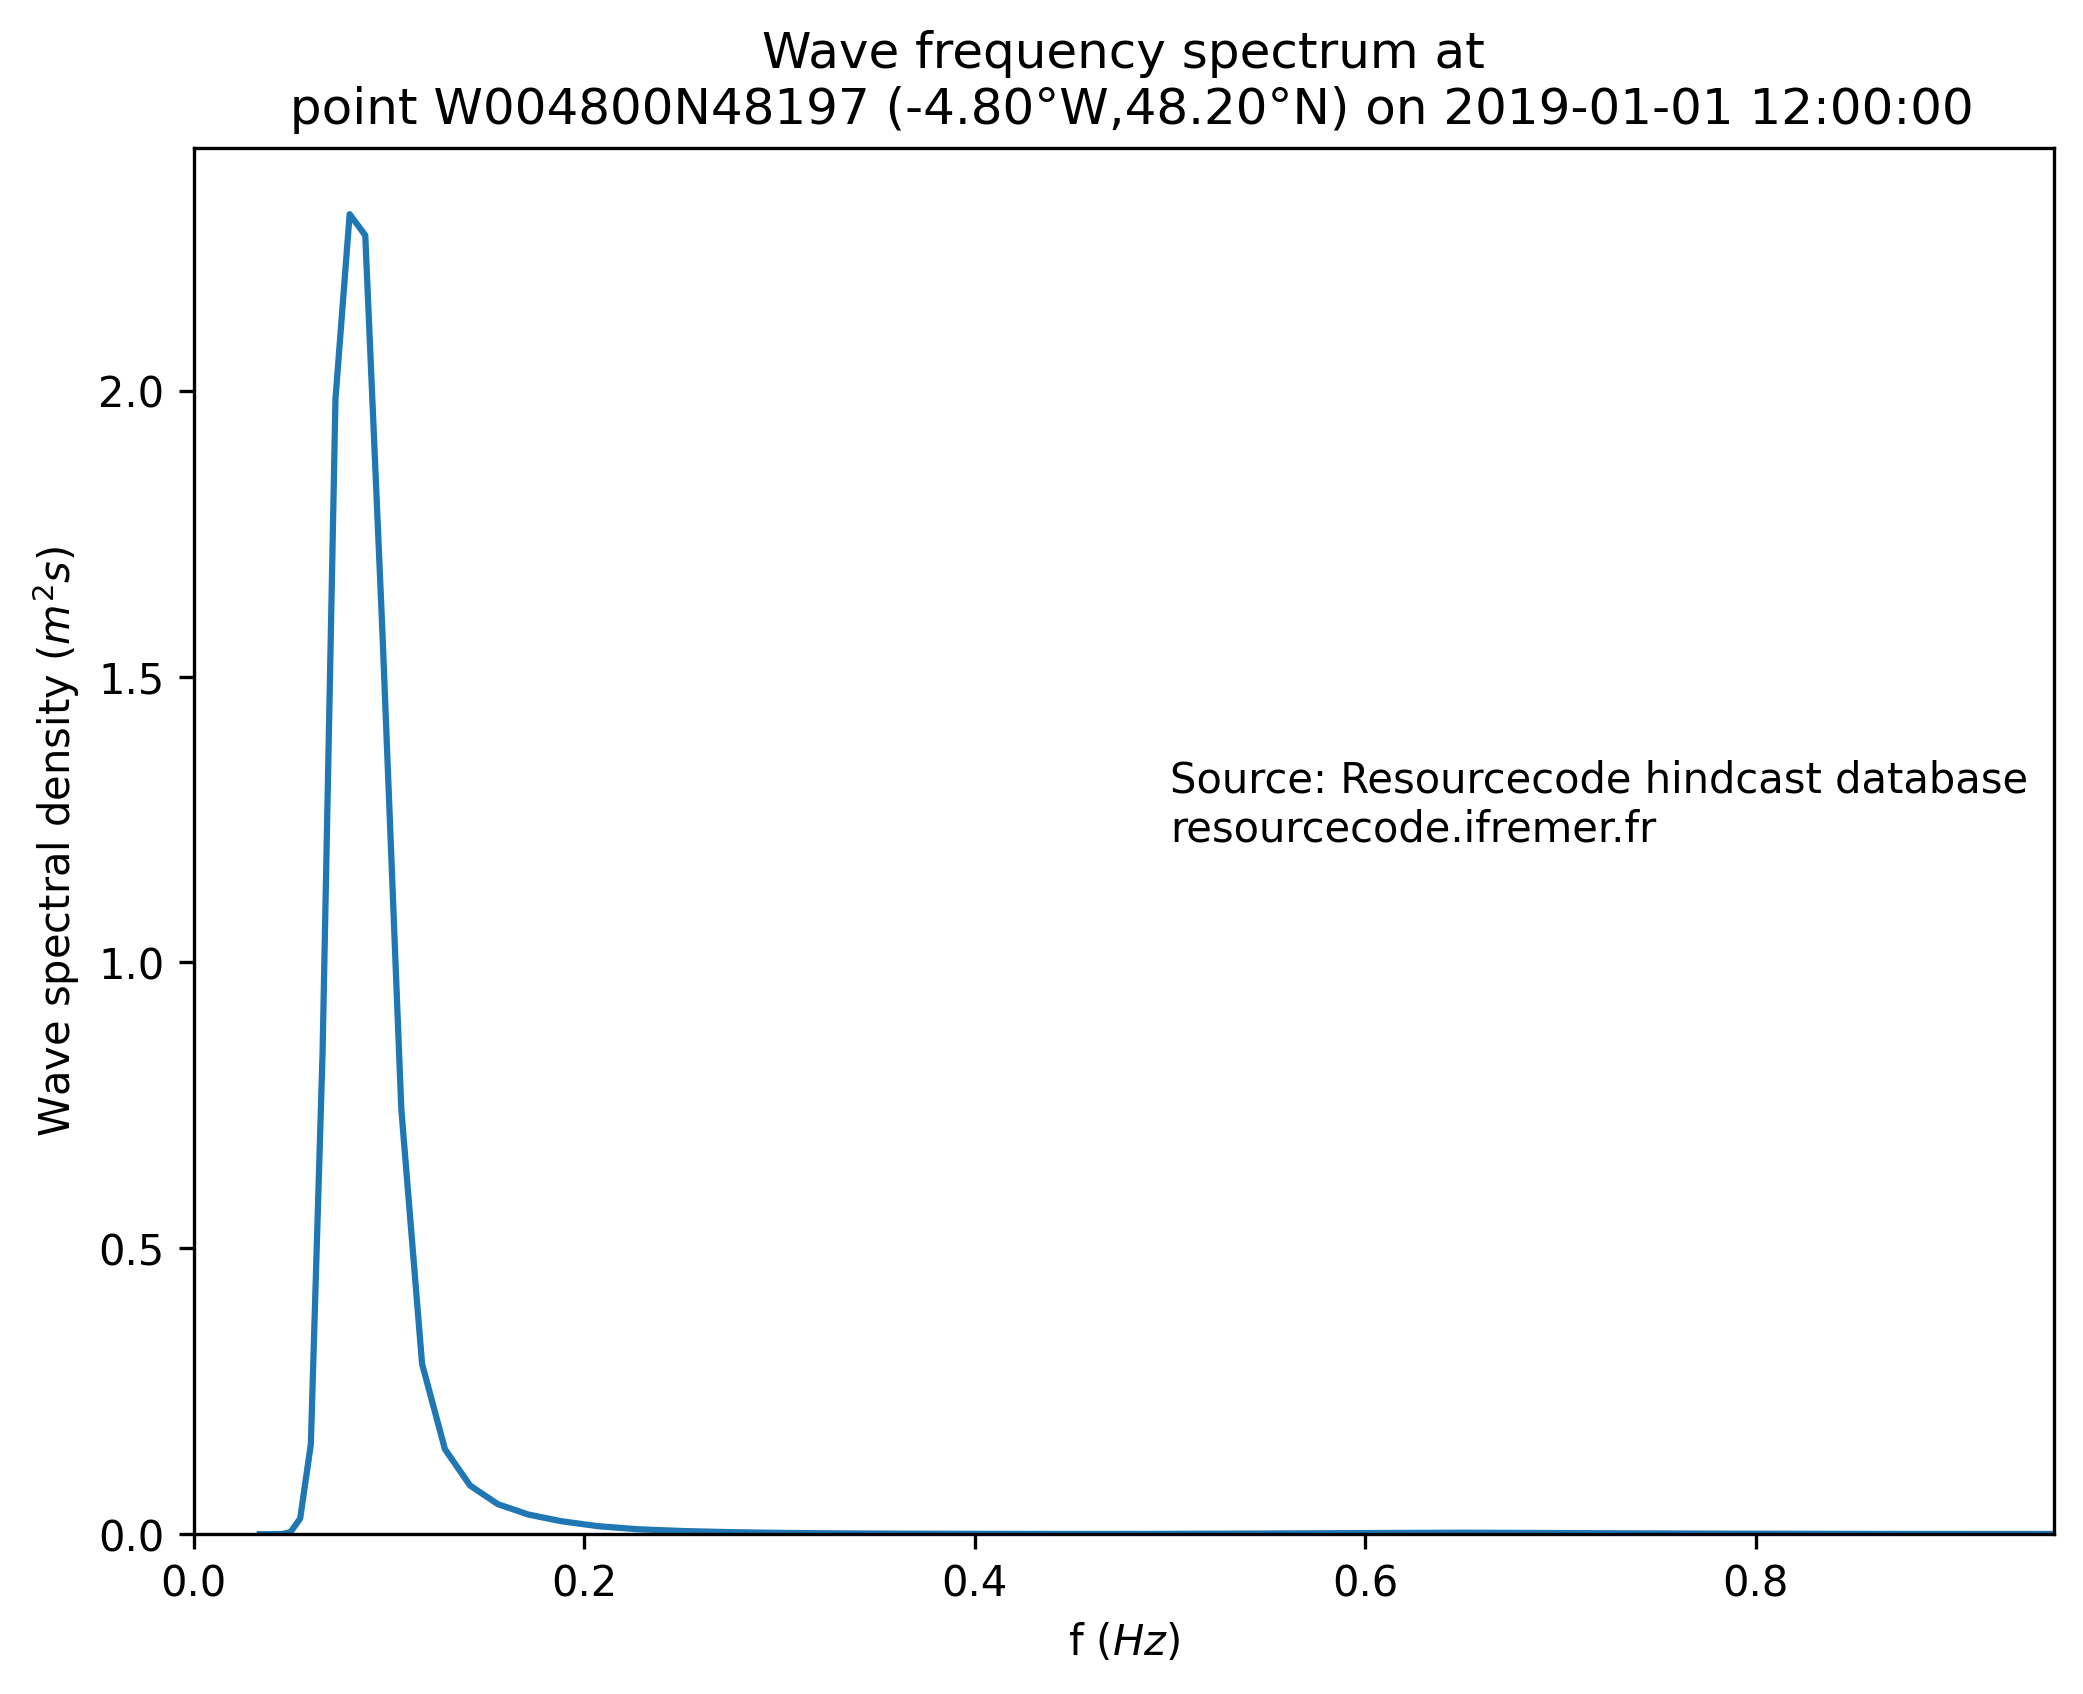

In [11]:
resourcecode.spectrum.plot_1D_spectrum(spec_1D,time=12,sea_state=False);

#### Sea-state parameters

The sea-state parameters can be computed from both the 2D and 1D spectrum, using the functions `compute_parameters_from_2D_spectrum` and `compute_parameters_from_1D_spectrum` respectively.

In [12]:
parameters = resourcecode.spectrum.compute_parameters_from_2D_spectrum(spec_2D,use_depth=True)

In [13]:
parameters.head()

time       Hm0         Tp        T01       T02         Te  \
0 2019-01-01 00:00:00  1.167721  11.836691  10.174480  9.569950  10.985298   
0 2019-01-01 01:00:00  1.159784  11.764478  10.119617  9.499341  10.954024   
0 2019-01-01 02:00:00  1.141387  11.800474  10.091277  9.306508  10.994356   
0 2019-01-01 03:00:00  1.118562  11.909795  10.088951  9.039169  11.101722   
0 2019-01-01 04:00:00  1.095242  12.058747  10.248199  9.211139  11.284469   

         mu        nu          CgE        km          lm  depth      Thetam  \
0  0.339562  0.361012  8297.462595  0.045780  137.248670   52.5  263.651077   
0  0.344720  0.367229  8166.816172  0.046470  135.210552   52.0  263.774355   
0  0.386635  0.419238  7956.068687  0.048413  129.784286   51.5  263.855853   
0  0.444160  0.495744  7744.250755  0.051319  122.433052   51.0  263.660182   
0  0.438347  0.487700  7591.721646  0.049711  126.395176   50.0  263.007407   

      Thetapm        Spr        Qp  wnd     wnddir  cur      curdir  
0  261.238183  21.487228  2.802772  2.6  67.700005  0.1  328.899994  
0  261.496965  22.123853  2.766519  2.8  67.599998  0.2    0.000000  
0  261.708599  22.444956  2.723770  3.1  68.599998  0.2   11.900001  
0  261.775896  22.816601  2.714182  2.9  71.599998  0.2   20.500000  
0  262.844124  22.829420  2.769339  2.6  72.500000  0.2   30.600000

In [14]:
parameters_1D = resourcecode.spectrum.compute_parameters_from_1D_spectrum(spec_1D,use_depth=True)

In [15]:
parameters_1D.head()

time       Hm0         Tp        T01       T02         Te  \
0 2019-01-01 00:00:00  1.167721  11.836691  10.174480  9.569950  10.985298   
0 2019-01-01 01:00:00  1.159784  11.764478  10.119617  9.499341  10.954024   
0 2019-01-01 02:00:00  1.141387  11.800474  10.091277  9.306508  10.994356   
0 2019-01-01 03:00:00  1.118562  11.909795  10.088951  9.039169  11.101722   
0 2019-01-01 04:00:00  1.095242  12.058747  10.248199  9.211139  11.284469   

         mu        nu            CgE        km          lm  depth Thetam  \
0  0.339562  0.361012   97361.514855  0.045780  137.248670   52.5   None   
0  0.344720  0.367229   97144.532024  0.046470  135.210552   52.0   None   
0  0.386635  0.419238   97713.163396  0.048413  129.784286   51.5   None   
0  0.444160  0.495744   99032.774714  0.051319  122.433052   51.0   None   
0  0.438347  0.487700  101260.563656  0.049711  126.395176   50.0   None   

  Thetapm   Spr    Qp  wnd     wnddir  cur      curdir  
0    None  None  None  2.6  67.700005  0.1  328.899994  
0    None  None  None  2.8  67.599998  0.2    0.000000  
0    None  None  None  3.1  68.599998  0.2   11.900001  
0    None  None  None  2.9  71.599998  0.2   20.500000  
0    None  None  None  2.6  72.500000  0.2   30.600000